In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import rdata
frequency = rdata.read_rda("data//fremotor1freq0304a.rda")
premium = rdata.read_rda("data//fremotor1prem0304a.rda")
severity = rdata.read_rda("data//fremotor1sev0304a.rda")
freq_df = frequency["fremotor1freq0304a"]
prem_df = premium["fremotor1prem0304a"]
sev_df = severity["fremotor1sev0304a"]
sev_df["OccurDate"] = pd.to_datetime(sev_df["OccurDate"], unit="D", origin="unix")
sev_df["OccurYear"] = sev_df["OccurDate"].dt.year
prem_df["DrivAgeBins"] = pd.cut(prem_df["DrivAge"],bins=20).map(lambda x: "(%s,%s]" % (x.left, x.right))

/opt/conda/lib/python3.12/site-packages/rdata/conversion/_conversion.py:856: UserWarning: Missing constructor for R class "Date". The underlying R object is returned instead.
  warnings.warn(


In [4]:
mask = sev_df["Guarantee"] == "Windscreen"
damage_df = sev_df.loc[mask,:]

In [5]:
enriched_df = pd.merge(prem_df, damage_df, left_on=["IDpol","Year"], right_on=["IDpol","OccurYear"])

In [6]:
vehclass_cat = ["Cheapest", "Cheaper", "Cheap", "Medium low", "Medium", "Medium high", "Expensive","More expensive", "Most expensive"]
vehpower_cat = ["P%s" % x for x in range(2,18)]
len(vehpower_cat)

16

In [7]:
enriched_df["VehClassOrd"] = enriched_df["VehClass"].map(lambda x: vehclass_cat.index(x))
enriched_df["VehPowerOrd"] = enriched_df["VehPower"].map(lambda x: vehpower_cat.index(x))

In [89]:
def vehclass_factor(ordinal):
    if ordinal < 3:
        return 1/9
    return (1+ordinal)/9

def vehpower_factor(ordinal):
    return (1+ordinal)/16

def calc_damage(row):
    return (5000*(vehclass_factor(row["VehClassOrd"])*vehpower_factor(row["VehPowerOrd"]))+np.random.random()*1000)

np.random.seed(42)
enriched_df["Damage"] = enriched_df.apply(calc_damage, axis=1)

In [90]:
X = enriched_df.loc[:, ["VehClassOrd","VehPowerOrd"]].values
y = enriched_df["Damage"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [91]:
from sklearn.tree import DecisionTreeRegressor
clf_tree = DecisionTreeRegressor(max_depth=10).fit(X_train, y_train)
print("The Tree model score is %.2f%%" % (clf_tree.score(X_test, y_test)*100))
y_tree = clf_tree.predict(X_test)

The Tree model score is 88.79%


In [92]:
from sklearn.linear_model import LinearRegression
clf_lin = LinearRegression().fit(X_train, y_train)
print("The Linear model score is %.2f%%" % (clf_lin.score(X_test, y_test)*100))
y_lin = clf_lin.predict(X_test)

The Linear model score is 72.24%


In [93]:
def perc_to_decile(val):
    if val == 1.0:
        return 10
    return int(val*10)+1

In [94]:
pred_df = pd.DataFrame({"Actual": y_test, "Tree": y_tree, "Lin": y_lin})
pred_df.sort_values("Tree", inplace=True)
pred_df["DecileTree"] = pred_df["Tree"].rank(pct=True).map(perc_to_decile)
pred_df.sort_values("Lin", inplace=True)
pred_df["DecileLin"] = pred_df["Lin"].rank(pct=True).map(perc_to_decile)

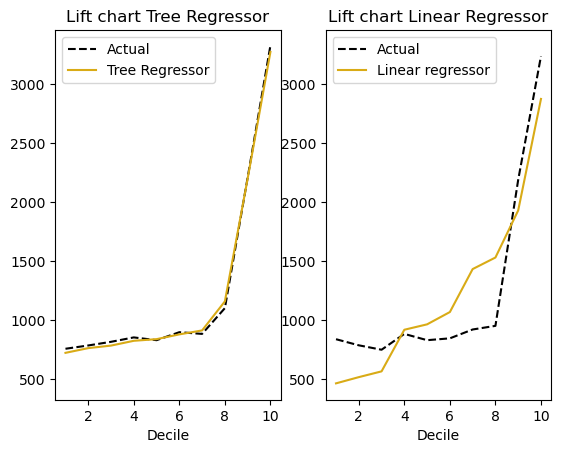

In [95]:
fig, ax = plt.subplots(1,2)

pred_df.loc[:,["DecileTree","Actual", "Tree"]].groupby("DecileTree").mean().plot(color = ["black", "#d9ab16"], style=["--","-"], ax=ax[0])
ax[0].legend(["Actual", "Tree Regressor"])
ax[0].set_title("Lift chart Tree Regressor")
tree_min, tree_max = ax[0].get_ylim()

pred_df.loc[:,["DecileLin","Actual", "Lin"]].groupby("DecileLin").mean().plot(color = ["black", "#d9ab16"], style=["--","-"], ax=ax[1])
ax[1].legend(["Actual", "Linear regressor"])
ax[1].set_title("Lift chart Linear Regressor")
lin_min, lin_max = ax[1].get_ylim()
y_min = min(tree_min, lin_min)
y_max = max(tree_max, lin_max)
ax[0].set_ylim(y_min, y_max)
ax[0].set_xlabel("Decile")
ax[1].set_ylim(y_min, y_max)
ax[1].set_xlabel("Decile")
plt.show()

In [96]:
pred_df = pd.DataFrame({"Actual": y_test, "Tree": y_tree, "Lin": y_lin})
pred_df["Model/Current"] = pred_df["Tree"]/pred_df["Lin"]
pred_df.sort_values("Model/Current", inplace=True)
pred_df["Decile"] = pred_df["Model/Current"].rank(pct=True).map(perc_to_decile)


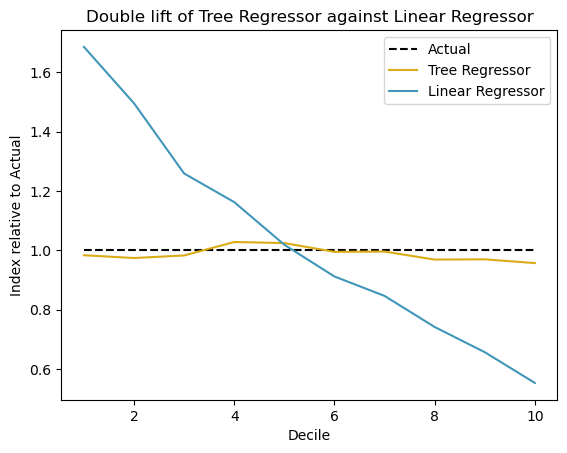

In [97]:
double_lift_df = pred_df.loc[:,["Decile","Actual", "Tree","Lin"]].groupby("Decile").mean()
double_lift_df["ActualIndex"] = 1
double_lift_df["TreeIndex"] = double_lift_df["Tree"]/double_lift_df["Actual"]
double_lift_df["LinIndex"] = double_lift_df["Lin"]/double_lift_df["Actual"]
double_lift_df.loc[:, [ "ActualIndex", "TreeIndex", "LinIndex"]].plot(color = ["black", "#d9ab16", "#4096b8"], style=["--","-","-"])
plt.legend(["Actual","Tree Regressor", "Linear Regressor"])
plt.title("Double lift of Tree Regressor against Linear Regressor")
plt.ylabel("Index relative to Actual")
plt.show()

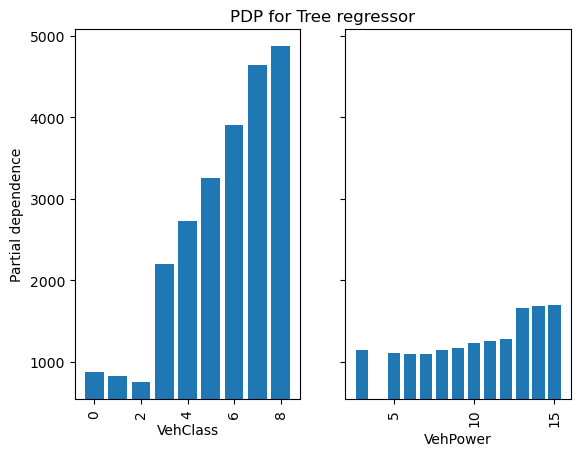

In [98]:
from sklearn.inspection import PartialDependenceDisplay

features = [0, 1]
fig, ax = plt.subplots()
PartialDependenceDisplay.from_estimator(clf_tree, X_train, features, feature_names=["VehClass", "VehPower"], ax=ax, categorical_features=[True, True])
ax.set_title("PDP for Tree regressor")
plt.show()

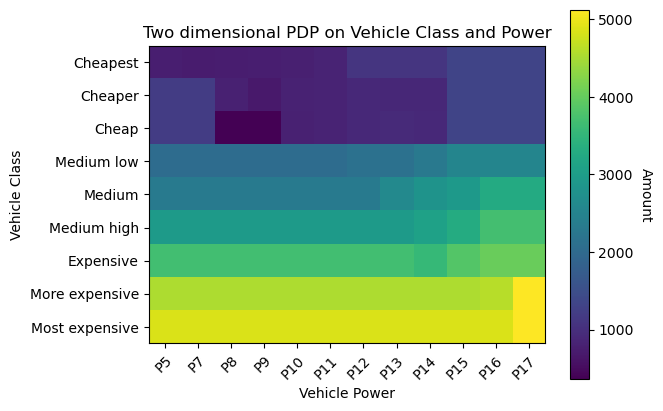

In [99]:
from sklearn.inspection import partial_dependence

features = [(0,1)]
pdp_output = partial_dependence(clf_tree, X_train, features, feature_names=["VehClass", "VehPower"], categorical_features=[True, True])
x_labels = [vehpower_cat[i] for i in pdp_output["grid_values"][1]]
y_labels = [vehclass_cat[i] for i in pdp_output["grid_values"][0]]
fig, ax = plt.subplots()
im = ax.imshow(pdp_output["average"][0])
ax.set_xticks(range(len(x_labels)), labels=x_labels,
              rotation=45, ha="right", rotation_mode="anchor")
ax.set_xlabel("Vehicle Power")
ax.set_yticks(range(len(y_labels)), labels=y_labels)
ax.set_ylabel("Vehicle Class")

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Amount", rotation=-90, va="bottom")
ax.set_title("Two dimensional PDP on Vehicle Class and Power")
plt.show()

In [100]:
import shap
explainer = shap.Explainer(clf_tree)
explanation = explainer(X_test)

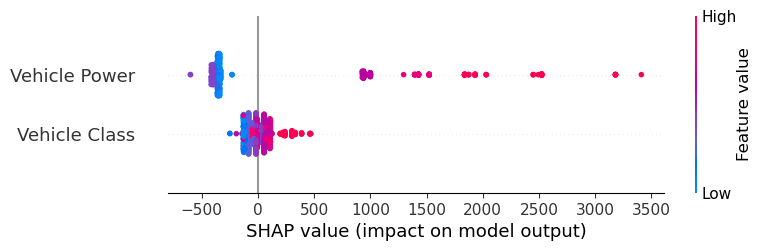

In [101]:
fig, ax = plt.subplots()
ax = shap.plots.beeswarm(explanation, show=False)
ax.set_yticklabels(["Vehicle Class","Vehicle Power"])
plt.show()

In [102]:
enriched_df.head()

,IDpol,Year,DrivAge,DrivGender,MaritalStatus,BonusMalus,LicenceNb,PayFreq,JobCode,VehAge,...,PremTot,DrivAgeBins,OccurDate,Payment,IDclaim,Guarantee,OccurYear,VehClassOrd,VehPowerOrd,Damage
0,1001133.100b,2003.0,32.0,M,Cohabiting,72.0,1.0,Half-yearly,Public employee,7.0,...,510.7,"(29.85,33.8]",2003-03-08,46,9623,Windscreen,2003,0,7,652.317897
1,1001319.101a,2003.0,32.0,F,Cohabiting,80.0,2.0,Half-yearly,Private employee,13.0,...,490.5,"(29.85,33.8]",2003-12-08,351,208632,Windscreen,2003,3,11,2617.380973
2,1001560.100a,2003.0,33.0,M,Cohabiting,50.0,1.0,Half-yearly,Private employee,7.0,...,198.7,"(29.85,33.8]",2003-05-14,198,13240,Windscreen,2003,2,10,1113.938386
3,1001590.100b,2003.0,24.0,F,Cohabiting,80.0,2.0,Half-yearly,Private employee,7.0,...,462.9,"(21.95,25.9]",2003-10-01,443,205490,Windscreen,2003,0,5,806.991818
4,1001688.100a,2003.0,46.0,M,Cohabiting,61.0,2.0,Half-yearly,Craftsman,9.0,...,519.9,"(45.65,49.6]",2003-04-22,134,11554,Windscreen,2003,2,10,537.963085


In [126]:
pred_out_df = enriched_df.loc[:,["IDpol","PremTot", "Damage","Year"]]
pred_out_df["TreePred"] = clf_tree.predict(X)
pred_out_df["LinearPred"] = clf_lin.predict(X)
pred_out_df["LR"] = pred_out_df["Damage"]/pred_out_df["PremTot"]
pred_out_df.sort_values("LR", inplace=True)
pred_out_df["Decile"] = pred_out_df["LR"].rank(pct=True).map(perc_to_decile)
lr_ranking = pred_out_df.loc[:,["Decile","PremTot","Damage","TreePred","LinearPred"]].groupby("Decile").sum().reset_index()
lr_ranking["Actual LR"] = lr_ranking["Damage"]/lr_ranking["PremTot"]
lr_ranking["Tree LR"] = lr_ranking["TreePred"]/lr_ranking["PremTot"]
lr_ranking["Linear LR"] = lr_ranking["LinearPred"]/lr_ranking["PremTot"]

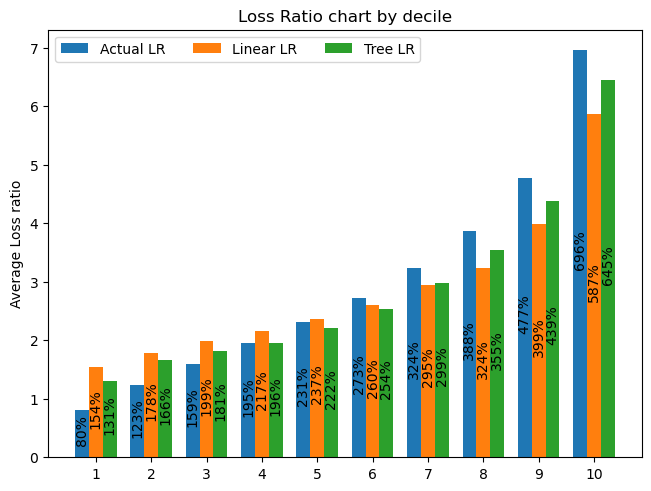

In [149]:
# data from https://allisonhorst.github.io/palmerpenguins/

import matplotlib.pyplot as plt
import numpy as np

deciles = lr_ranking["Decile"].values
means = {
    'Actual LR': lr_ranking["Actual LR"].values,
    'Linear LR': lr_ranking["Linear LR"].values,
    'Tree LR': lr_ranking["Tree LR"].values,
}

x = np.arange(len(deciles))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, 
                 labels=["%.0f%%" % (x*100) for x in measurement],
                 label_type="center",
                 padding=3, 
                 rotation=90)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Loss ratio')
ax.set_title('Loss Ratio chart by decile')
ax.set_xticks(x + width, deciles)
ax.legend(loc='upper left', ncols=3)
plt.show()